Imports:

In [8]:
from train_for_real import *
import pickle

# #Scientific computing 
# import numpy as np
# #Pytorch packages
# import torch
from torch import nn
import torch.optim as optim
from tensorboardX import SummaryWriter
#Visulization
#from tqdm import tqdm
from tqdm.notebook import tqdm
import monai
# finetuneSAM\models\sam_LoRa.py
from finetuneSAM.models.sam_LoRa import LoRA_Sam


In [9]:
from finetuneSAM.cfg import parse_args
#Fine-Tune Sam
args =  parse_args()


# setting if_mask_decoder_adapter = True puts adapters inside 2-way transformer blocks
# this does not change the number of decoder 2-way transformer blocks (def = 2)
# decoder_adapt_depth denotes how many of the two 2-way transformer blocks are adapted


# setting if_encoder_adapter = True puts adapters inside TinyViTBlocks in the encoder
# this does not change the number of encoder TinyViTBlocks (def = 4)
# encoder_adapt_depth (e.g. [1,2]) denotes how deep blocks will be adapted


# parser.add_argument('-if_update_encoder', type=bool, default=False , help='if update_image_encoder')
# parser.add_argument('-if_encoder_adapter', type=bool, default=False , help='if add adapter to encoder')

# parser.add_argument('-encoder-adapter-depths', type=list, default=[0,1,10,11] , help='the depth of blocks to add adapter')
# parser.add_argument('-if_mask_decoder_adapter', type=bool, default=False , help='if add adapter to mask decoder')
# parser.add_argument('-decoder_adapt_depth', type=int, default=2, help='the depth of the decoder adapter')

# parser.add_argument('-if_encoder_lora_layer', type=bool, default=False , help='if add lora to encoder')
# parser.add_argument('-if_decoder_lora_layer', type=bool, default=False , help='if add lora to decoder')
# parser.add_argument('-encoder_lora_layer', type=list, default=[0,1,10,11] , help='the depth of blocks to add lora, if [], it will add at each layer')

#    parser.add_argument('-finetune_type', type=str, default='adapter', help='normalization type, pick among vanilla,adapter,lora')

args.finetune_type = "adapter"


#args.finetune_type = "vanilla"
#args.finetune_type = "adapter"# "vanilla"
#args.if_mask_decoder_adapter = True


#decoder
args.finetune_type = "adapter"
args.if_mask_decoder_adapter = True

# #encoder
# args.finetune_type = "adapter"
# args.if_encoder_adapter = True
# args.if_update_encoder = True

# #lora decoder
# args.finetune_type = "lora"
# args.if_decoder_lora_layer = True






args.num_cls = 3




In [10]:
sam = load_model(args)


with open('train_data.pkl', 'rb') as file:
    data = pickle.load(file)

train_points = len(data['image'])
checkpoints_path = 'checkpoints'

    
val_percentage = 0.15
val_points = int(train_points*val_percentage)
train_points = train_points - val_points
print('Train points:',train_points)

val_data = {"image":[],"mask":[],"points":[],"p_labels":[]}
for i in range(val_points):
    rnd_indx = np.random.randint(0,len(data["image"])-1)
    val_data["image"].append(data["image"].pop(rnd_indx))
    val_data["mask"].append(data["mask"].pop(rnd_indx))
    val_data['points'].append(data['points'].pop(rnd_indx))
    val_data['p_labels'].append(data['p_labels'].pop(rnd_indx))
    
train_data = data

train_data = EyeData(train_data)

val_data = EyeData(val_data)




if args.finetune_type == 'adapter':
        for n, value in sam.named_parameters():
            if "Adapter" not in n: # only update parameters in adapter
                value.requires_grad = False
        print('if update encoder:',args.if_update_encoder)
        print('if image encoder adapter:',args.if_encoder_adapter)
        print('if mask decoder adapter:',args.if_mask_decoder_adapter)
        if args.if_encoder_adapter:
            print('added adapter layers:',args.encoder_adapter_depths)
elif args.finetune_type == 'lora':
    print('if update encoder:',args.if_update_encoder)
    print('if image encoder lora:',args.if_encoder_lora_layer)
    print('if mask decoder lora:',args.if_decoder_lora_layer)
    for n, value in sam.named_parameters():
        value.requires_grad = False
    sam = LoRA_Sam(args,sam,r=4).sam

sam.to('cuda')



sammy = Sammy(sam, (512,512))

Train points: 60
if update encoder: False
if image encoder adapter: False
if mask decoder adapter: True


In [11]:
def adjust_lr(losses, rates):
    # if improvement is less than 0.1% stop training
    # 0.30 , 0.25
    l3 = losses[-1]
    l2 = losses[-2]
    l1 = losses[-3]
    d1 = l2 - l1
    d2 = l3 - l2
    mean_diff = (d1 + d2) / 2
    #print('mean_diff:',mean_diff)
    x = abs(mean_diff)

    last_loss = losses[-1]
    curr_rate = rates[-1]
    
    regress = mean_diff > 0


    is_lvl1 = (regress or  x < 0.01  ) and ( last_loss > 0.5 )
    is_lvl2 = (regress or  x < 0.005  ) and ( ( (last_loss < 0.5) and  (last_loss > 0.4 ) ) )
    is_lvl3 = (regress or  x < 0.003  ) and ( ( (last_loss < 0.4) and  (last_loss > 0.35) ) )
    is_lvl4 = (regress or  x < 0.002  ) and ( ( (last_loss < 0.35)  ) )


    if is_lvl1:
        print("Level 1 adjustment: ",x, ' < ',0.01)
        if curr_rate > 0.0005:
            return curr_rate * 0.5
        else:
            return 0.01
    elif is_lvl2:
        print("Level 2 adjustment: ",x, ' < ',0.005)
        if curr_rate > 0.0001:
            return curr_rate * 0.25
        else:
            return 0.005
    elif is_lvl3:
        print("Level 3 adjustment: ",x, ' < ',0.003)
        if curr_rate > 0.00005:
            return curr_rate * 0.1
        else:
            return 0.001
    elif is_lvl4:
        print("Level 4 adjustment: ",x, ' < ',0.002)
        if curr_rate > 0.00001:
            return curr_rate * 0.1
        else:
            return 0.0005
    else:
        print("No adjustment: ",x)
        return curr_rate

    
    
    

In [12]:
# print leanable parameters with grad true
for n, value in sam.named_parameters():
    if value.requires_grad:
        print(n)


mask_decoder.transformer.layers.0.MLP_Adapter.D_fc1.weight
mask_decoder.transformer.layers.0.MLP_Adapter.D_fc1.bias
mask_decoder.transformer.layers.0.MLP_Adapter.D_fc2.weight
mask_decoder.transformer.layers.0.MLP_Adapter.D_fc2.bias
mask_decoder.transformer.layers.0.Adapter.D_fc1.weight
mask_decoder.transformer.layers.0.Adapter.D_fc1.bias
mask_decoder.transformer.layers.0.Adapter.D_fc2.weight
mask_decoder.transformer.layers.0.Adapter.D_fc2.bias
mask_decoder.transformer.layers.1.MLP_Adapter.D_fc1.weight
mask_decoder.transformer.layers.1.MLP_Adapter.D_fc1.bias
mask_decoder.transformer.layers.1.MLP_Adapter.D_fc2.weight
mask_decoder.transformer.layers.1.MLP_Adapter.D_fc2.bias
mask_decoder.transformer.layers.1.Adapter.D_fc1.weight
mask_decoder.transformer.layers.1.Adapter.D_fc1.bias
mask_decoder.transformer.layers.1.Adapter.D_fc2.weight
mask_decoder.transformer.layers.1.Adapter.D_fc2.bias


In [13]:
# TRAINING LOOP
b_lr = 0.01
if args.if_warmup:
    b_lr = 0.01

epochs = 64
batch_size = 5

optimizer = optim.AdamW(sam.parameters(), lr=b_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1, amsgrad=False)
optimizer.zero_grad()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7) #learning rate decay

criterion1 = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction='mean')
criterion2 = nn.BCEWithLogitsLoss()
iter_num = 0
max_iterations = epochs * train_points
writer = SummaryWriter(checkpoints_path + '/log')

pbar = tqdm(range(epochs))
val_largest_dsc = 0
last_update_epoch = 0
print('Start training')

mask_downscale_f = Upsample(scale_factor=0.5)

#args.if_warmup = True
args.warmup_period = 20


is_warmup_over = not args.if_warmup
train_data.divide_into_batches(batch_size)
print("Number of batches: ",len(train_data.batches))
print("Batches pr epoch: ",len(train_data.batches))




lrs = []
lss = []


for epoch in pbar:
    print('Epoch num {}'.format(epoch))
    sam.train()
    train_loss = 0
    train_data.divide_into_batches(batch_size)

    
    if args.if_warmup and epoch < args.warmup_period:
            
            # s = ((2*args.warmup_period)+1) / (epoch+1 )
            # scalar = min(max(s,2.5),8)
            l = [0.9,0.8,0.75,0.72,0.7,0.68,0.66,0.64,0.62,0.6,0.58,0.56,0.54,0.52,0.5,0.48,0.46,0.44,0.42,0.4]
            scalar = l[epoch]
            lr_ = b_lr * (5*scalar)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_
            # set also for scheduler
            for param_group in scheduler.optimizer.param_groups:
                param_group['lr'] = lr_

    elif args.if_warmup and epoch == args.warmup_period:
        is_warmup_over = True
        b_lr = 0.01
        print('**Warmup is over**')
        for param_group in optimizer.param_groups:
            param_group['lr'] = b_lr
        # set also for scheduler
        for param_group in scheduler.optimizer.param_groups:
            param_group['lr'] = b_lr


    b_bar = tqdm(range(len(train_data.batches)))

    for i in b_bar:

        batch = train_data.batches[i]
        imgs = batch['image']
        msks = batch['mask']
        points = batch['points']
        labels = batch['p_labels']


        if args.if_update_encoder:
            img_emb = sammy.encode_img(imgs)
        else:
            with torch.no_grad():
                img_emb = sammy.encode_img(imgs)
        
        sparse_emb, dense_emb = sammy.encode_promts(points=points, labels=labels)




        _,pred = sammy.decode_features(img_emb, sparse_emb, dense_emb)

        


        msks = torch.tensor(msks).float().cuda()
        # from Bx512x512 to Bx1x512x512
        msks = msks.unsqueeze(1)
        # from 512x512 to 256x256
        msks = mask_downscale_f(msks)
        
        
        
        loss_dice =  criterion1(pred,msks)
        loss_ce = criterion2(pred,msks)
        loss =  loss_dice + loss_ce


        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item()
        iter_num+=1

        if is_warmup_over:
            writer.add_scalar('info/lr', scheduler.get_last_lr(), iter_num)
        else:
            writer.add_scalar('info/lr', lr_, iter_num)
        writer.add_scalar('info/total_loss', loss, iter_num)
        writer.add_scalar('info/loss_ce', loss_ce, iter_num)
        #writer.add_scalar('info/loss_dice', loss_dice, iter_num)
    

    

    train_loss /= (i+1)
    #pbar.set_description('Epoch num {}| train loss {} | lr {} \n'.format(epoch,train_loss,optimizer.param_groups[0]['lr']))
    print('Epoch num {}| train loss {} | lr_opt {} | lr_sch {}\n'.format(epoch,train_loss,optimizer.param_groups[0]['lr'],scheduler.get_last_lr()))

    lss.append(train_loss)
    lrs.append(optimizer.param_groups[0]['lr'])
    if len(lss) > 3:
        b_lr = adjust_lr(lss, lrs)
        #print("adjust_lr:",b_lr)
        if b_lr != optimizer.param_groups[0]['lr']:
            for param_group in optimizer.param_groups:
                param_group['lr'] = b_lr
            lss = []
            lrs = []
        else:
            lss.pop(0)
            lrs.pop(0)

        
        


    # if is_warmup_over:
    #     scheduler.step()



    if epoch > 5 and not epoch%2==0:
        
        eval_loss=0
        dsc = 0
        sam.eval()
        with torch.no_grad():
            train_data.divide_into_batches(batch_size)
            for i in range(len(train_data.batches)):
                batch = train_data.batches[i]
                imgs = batch['image']
                msks = batch['mask']
                points = batch['points']
                labels = batch['p_labels']

                img_emb = sammy.encode_img(imgs)
                
                sparse_emb, dense_emb = sammy.encode_promts(points=points, labels=labels)
                _,pred = sammy.decode_features(img_emb, sparse_emb, dense_emb)

                msks = torch.tensor(msks).float().cuda()
                # from Bx512x512 to Bx1x512x512
                msks = msks.unsqueeze(1)
                # from 512x512 to 256x256
                msks = mask_downscale_f(msks)
                
                loss_dice =  criterion1(pred,msks)
                loss_ce = criterion2(pred,msks)
                loss =  loss_dice + loss_ce
                
                eval_loss +=loss.item()
                dsc_batch = 1-loss_dice
                dsc+=dsc_batch
                #print(dsc_batch)

            eval_loss /= (i+1)
            dsc /= (i+1)
            
            writer.add_scalar('eval/loss', eval_loss, epoch)
            writer.add_scalar('eval/dice', dsc, epoch)
            
            print('Eval Epoch num {} | val loss {} | dsc {} \n'.format(epoch,eval_loss,dsc))
            if dsc>val_largest_dsc:
                val_largest_dsc = dsc
                last_update_epoch = epoch
                print('largest DSC now: {}'.format(dsc))
                torch.save(sam.state_dict(),checkpoints_path + '/checkpoint_best.pth')
            elif (epoch-last_update_epoch)>20:
                # the network haven't been updated for 20 epochs
                print('Training finished###########')
                break
writer.close()

  0%|          | 0/64 [00:00<?, ?it/s]

Start training
Number of batches:  12
Batches pr epoch:  12
Epoch num 0


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 0| train loss 1.825961172580719 | lr_opt 0.01 | lr_sch [0.01]

Epoch num 1


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 1| train loss 0.854020819067955 | lr_opt 0.01 | lr_sch [0.01]

Epoch num 2


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 2| train loss 0.6722951581080755 | lr_opt 0.01 | lr_sch [0.01]

Epoch num 3


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 3| train loss 0.6460001866022745 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.10401031623284024
Epoch num 4


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 4| train loss 0.6220402965943018 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.025127430756886837
Epoch num 5


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 5| train loss 0.5878566801548004 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.029071753223737062
Epoch num 6


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 6| train loss 0.5367317174871763 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.04265428955356276
Epoch num 7


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 7| train loss 0.4891052842140198 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.04937569797039032
Eval Epoch num 7 | val loss 0.47201403975486755 | dsc 0.7316590547561646 

largest DSC now: 0.7316590547561646
Epoch num 8


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 8| train loss 0.46835750589768094 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.03418710579474768
Epoch num 9


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 9| train loss 0.44448184470335644 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.022311719755331666
Eval Epoch num 9 | val loss 0.4362313201030095 | dsc 0.7492612600326538 

largest DSC now: 0.7492612600326538
Epoch num 10


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 10| train loss 0.42942385872205097 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.019466823587814985
Epoch num 11


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 11| train loss 0.42534461120764416 | lr_opt 0.01 | lr_sch [0.01]

No adjustment:  0.00956861674785614
Eval Epoch num 11 | val loss 0.4342779591679573 | dsc 0.7579964995384216 

largest DSC now: 0.7579964995384216
Epoch num 12


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 12| train loss 0.4195070837934812 | lr_opt 0.01 | lr_sch [0.01]

Level 2 adjustment:  0.004958387464284897  <  0.005
Epoch num 13


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 13| train loss 0.4112638160586357 | lr_opt 0.0025 | lr_sch [0.01]

Eval Epoch num 13 | val loss 0.4021170238653819 | dsc 0.7687215805053711 

largest DSC now: 0.7687215805053711
Epoch num 14


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 14| train loss 0.40024879823128384 | lr_opt 0.0025 | lr_sch [0.01]

Epoch num 15


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 15| train loss 0.39846573770046234 | lr_opt 0.0025 | lr_sch [0.01]

Eval Epoch num 15 | val loss 0.396168681482474 | dsc 0.7737613916397095 

largest DSC now: 0.7737613916397095
Epoch num 16


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 16| train loss 0.39570796489715576 | lr_opt 0.0025 | lr_sch [0.01]

Level 3 adjustment:  0.0022704166670640402  <  0.003
Epoch num 17


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 17| train loss 0.3928491622209549 | lr_opt 0.00025 | lr_sch [0.01]

Eval Epoch num 17 | val loss 0.39250899106264114 | dsc 0.7741770148277283 

largest DSC now: 0.7741770148277283
Epoch num 18


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 18| train loss 0.39200517783562344 | lr_opt 0.00025 | lr_sch [0.01]

Epoch num 19


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 19| train loss 0.39288567503293353 | lr_opt 0.00025 | lr_sch [0.01]

Eval Epoch num 19 | val loss 0.391967348754406 | dsc 0.7746373414993286 

largest DSC now: 0.7746373414993286
Epoch num 20


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 20| train loss 0.39198970794677734 | lr_opt 0.00025 | lr_sch [0.01]

Level 3 adjustment:  7.734944423049006e-06  <  0.003
Epoch num 21


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch num 21| train loss 0.3924522176384926 | lr_opt 2.5e-05 | lr_sch [0.01]

Eval Epoch num 21 | val loss 0.39175523320833844 | dsc 0.774807870388031 

largest DSC now: 0.774807870388031
Epoch num 22


  0%|          | 0/12 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
from shit import test_model
test_model(sam,sammy)

Eval Loss: 0.38904473185539246, DSC: 0.7918639779090881


c:\Users\newma\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\losses\dice.py:156: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


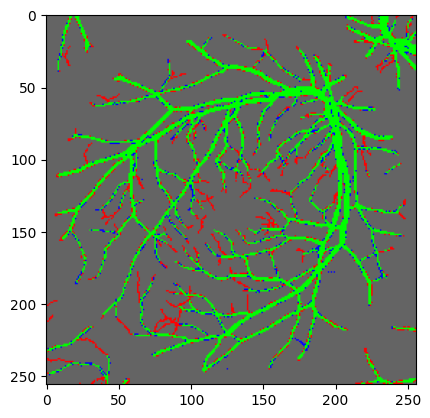

In [91]:
p = pred[1][0].detach().cpu().numpy()
m = msks[1][0].detach().cpu().numpy()
p = np.where(p > 0.5, 1, 0)
m = np.where(m > 0, 1, 0)
im = np.full((256,256,3),100)
# color green where m == p == 1
im[np.where((m==1) & (p==1))] = [0,255,0]
# color red where m == 1 and p == 0
im[np.where((m==1) & (p==0))] = [255,0,0]
# color blue where m == 0 and p == 1
im[np.where((m==0) & (p==1))] = [0,0,255]


# plot the mask
plt.imshow(im)

In [ ]:
def visualize_true_mask(mask,points, p_labels):
    f = Upsample(scale_factor=0.5)

    tru = mask
    
    points = points * 0.5
    lbls = p_labels
    

    tru = f(torch.tensor(tru)[None,None, :, :].float()).numpy()
    tru = tru[0][0]
    
    # plot only true mask
    fig, axs = plt.subplots(1, 1, figsize=(10,10))
    axs.imshow(tru, cmap='gray')
    
    #scatter points
    for i in range(len(points)):
        if lbls[i] == 1:
            axs.scatter(points[i][1], points[i][0], c='blue')#, s = 2)
        else:
            axs.scatter(points[i][1], points[i][0], c='red')#, s = 2)

    

In [ ]:
def visualize_predictions(true_mask, low_res_preds, points, p_labels):
    f = Upsample(scale_factor=0.5)
    # tru = org_data['mask'][0]
    # ponts = org_data['points'][0]
    # ponts = ponts * 0.5
    # lbls = org_data['p_labels'][0]

    tru = true_mask
    ponts = points
    ponts = ponts * 0.5
    lbls = p_labels
    

    tru = f(torch.tensor(tru)[None,None, :, :].float()).numpy()
    tru = tru[0][0]
    preds = low_res_masks[0].detach().cpu().numpy()
    preds = np.where(preds > 0.5, 1, 0)
    print(tru.shape)
    print(preds[0].shape)

    # plot three subplots each for tru and a class prediction
    fig, axs = plt.subplots(3,1)
    fig.suptitle('Predictions for Image 1')
    axs[0,].set_title('Prediction 1')
    tNp = tru + preds[0]*5
    axs[0].imshow(tNp)
    # scatter points   
    for i in range(len(ponts)):
        if lbls[i] == 1:
            axs[0].scatter(ponts[i][1], ponts[i][0], c='blue', s = 2)
        else:
            axs[0].scatter(ponts[i][1], ponts[i][0], c='red', s = 2)


    axs[1].set_title('Prediction 2')
    tNp = tru + preds[1]*5
    axs[1].imshow(tNp)
    # scatter points
    for i in range(len(ponts)):
        if lbls[i] == 1:
            axs[1].scatter(ponts[i][1], ponts[i][0], c='blue', s = 2)
        else:
            axs[1].scatter(ponts[i][1], ponts[i][0], c='red', s = 2)


    axs[2].set_title('Prediction 3')
    tNp = tru + preds[2]*5
    axs[2].imshow(tNp)
    # scatter points with size 2pxs
    for i in range(len(ponts)):
        if lbls[i] == 1:
            axs[2].scatter(ponts[i][1], ponts[i][0], c='blue', s = 2)
        else:
            axs[2].scatter(ponts[i][1], ponts[i][0], c='red', s = 2)
    plt.show()






# # 3 masks for 3 classes
# img1_masks = low_res_masks[0]
# # # # plot low res masks
# plt.imshow(img1_masks[].detach().cpu().numpy())
# plt.show()